# Forecasting in Aquaponics

Libraries and setup

In [110]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Initialize Horovod
hvd.init()

# Parameters for figures
mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

# Set seed
np.random.seed(10)

Check how many GPUs we are using

In [111]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  4


## Data adquisition

### Data adquisition

In [107]:
def read_file(textfile):
    df = pd.read_csv(textfile, compression='zip', sep="\t")
    df.drop(df.columns[0], axis=1, inplace=True)
    print('Dataset ready')
    return df

textfile = "dataset_aquaponics_03012021_05222021.txt.zip"
df = read_file(textfile)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_aquaponics_03012021_05222021.txt.zip'

Organize data in columns

In [86]:

df_grouped = pd.pivot_table(df, index = 'DateTime', columns = 'Label', values = 'Value')
df_grouped.index = pd.to_datetime(df_grouped.index)

start_date = pd.to_datetime('2021-03-17 00:00:00')
end_date = pd.to_datetime('2021-05-22 23:59:59')

df_grouped = df_grouped.loc[start_date:end_date]
print(df_grouped.head())

Label                      1          2         3       4       5    \
DateTime                                                              
2021-03-17 00:00:14  16.409998  60.726665      0.00  6.7044  6.6820   
2021-03-17 00:00:42  16.406000  60.923004      0.00  6.7047  6.6820   
2021-03-17 00:01:09  16.412000  60.940002      0.00  6.7050  6.6819   
2021-03-17 00:06:50  16.371998  59.305553 -99999.99  6.7035  6.6792   
2021-03-17 00:07:16  16.367500  60.477780  -2806.00  6.7036  6.6810   

Label                      6          7       8       9       10   ...  \
DateTime                                                           ...   
2021-03-17 00:00:14  47.336426  40.645813  100.83  97.179  13.060  ...   
2021-03-17 00:00:42  47.335526  40.644165  100.85  97.139  13.058  ...   
2021-03-17 00:01:09  47.337580  40.642605  100.86  97.126  13.059  ...   
2021-03-17 00:06:50  45.667645  44.009052  100.87  96.994  13.063  ...   
2021-03-17 00:07:16  45.667736  44.007435  100.89  97.000 

Data visualization

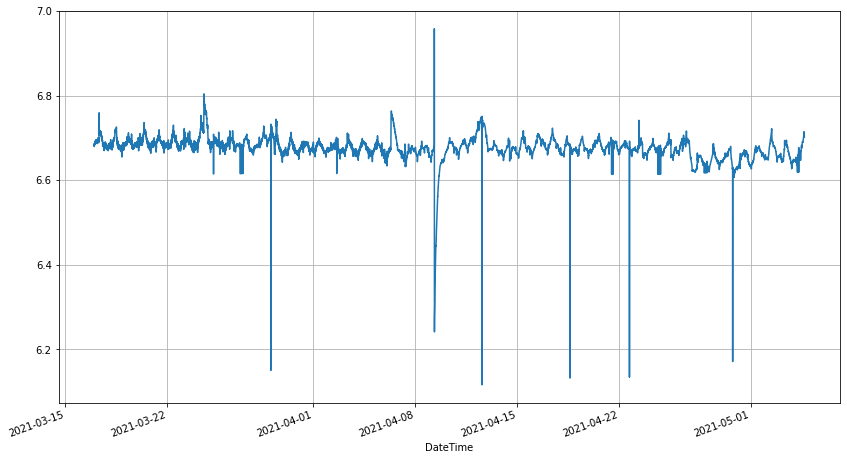

In [87]:
sample_sensor = 5

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

## Data Pre-processing

### Selecting target 

Target variables:

* 4     = pH sump B
* 5     = pH sump A
* 8     = % oxygen B
* 9     = % oxygen A
* 93*   = Weight cell 1
* 99*   = Nitrate B 
* 100*  = Ammonia B
* 103*  = Nitrate A 
* 104*  = Ammonia A

These sensors are not online yet*

In [88]:
label_target = {
# 4: 'pH sump B',
5: 'pH sump A',}
# 8: '% oxygen B',}
# 9: '% oxygen A'}

### Select features - Human knowledge

In [89]:
drop_signal = [3, 12, 13, 14, 15, 22, 23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 56, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 93, 94, 95, 97, 98, 99, 100, 101, 104, 105, 106, 111, 112, 113, 114]
df_grouped  = df_grouped.drop(columns = drop_signal)
print(df_grouped.head())

Label                      1          2       4       5          6    \
DateTime                                                               
2021-03-17 00:00:14  16.409998  60.726665  6.7044  6.6820  47.336426   
2021-03-17 00:00:42  16.406000  60.923004  6.7047  6.6820  47.335526   
2021-03-17 00:01:09  16.412000  60.940002  6.7050  6.6819  47.337580   
2021-03-17 00:06:50  16.371998  59.305553  6.7035  6.6792  45.667645   
2021-03-17 00:07:16  16.367500  60.477780  6.7036  6.6810  45.667736   

Label                      7       8       9       10      11   ...    91   \
DateTime                                                        ...          
2021-03-17 00:00:14  40.645813  100.83  97.179  13.060  13.340  ...  391.0   
2021-03-17 00:00:42  40.644165  100.85  97.139  13.058  13.341  ...  391.0   
2021-03-17 00:01:09  40.642605  100.86  97.126  13.059  13.344  ...  391.0   
2021-03-17 00:06:50  44.009052  100.87  96.994  13.063  13.408  ...  391.0   
2021-03-17 00:07:16  44.007

### Denoising dataframe - FFT filter

Check sampling frecuency

In [90]:
sampling_time = df_grouped.index.to_series().diff().median()
print(sampling_time)

0 days 00:00:25


Design sample filter

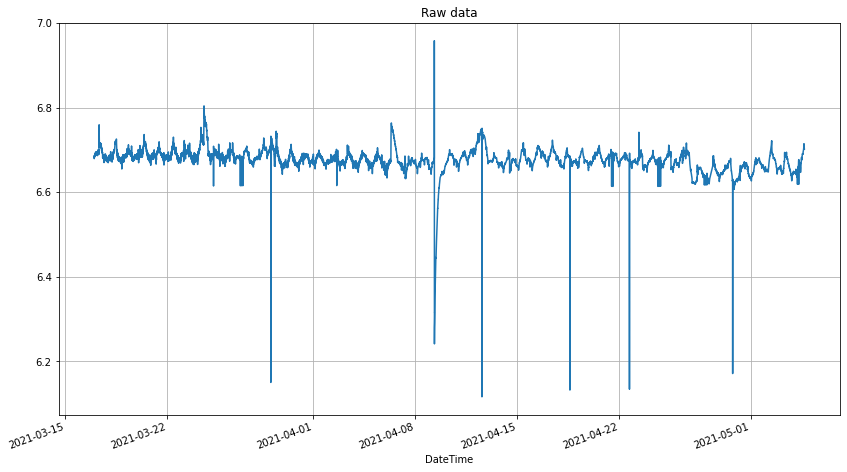

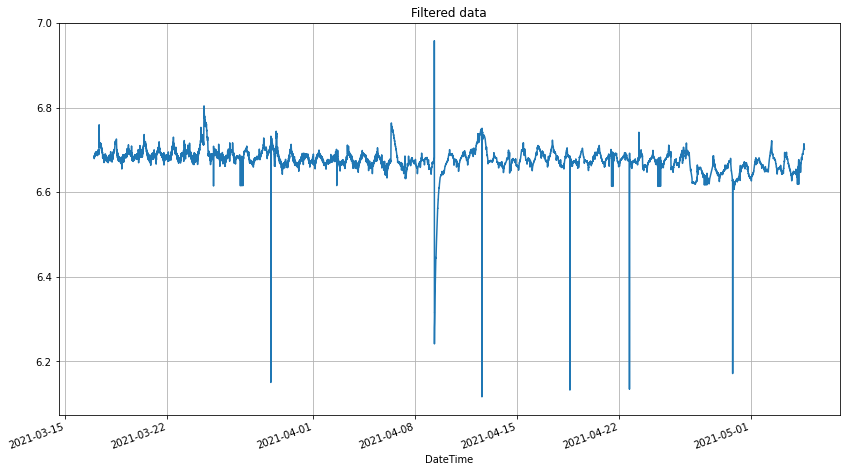

In [91]:
def f_filtering(df, cutt_fc):
    
    new_df = df.copy() 
    index = df.index
    
    dt = 25 # seconds
    n_samples = new_df.shape[0]
    
    # Fast Fourier transform
    f_hat = np.fft.fft(df.to_numpy())
    f_mag_2 = np.real(f_hat * np.conj(f_hat)) / n_samples
    fc_df = (1 / (dt * n_samples)) * np.arange(n_samples)
    
    # Cutting frecuency
    ind_filter = f_mag_2 > cutt_fc
    
    # Filter signal
    f_hat_clean = f_hat * ind_filter
    filter_signal = np.fft.ifft(f_hat_clean)
    
    
    filter_signal = np.real(filter_signal)
    
    return filter_signal

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Raw data')
plt.show()

# Cutting frecuency
cutt_fc = {
1: 5,   
2: 150,     
4: 0.001,   
5: 0.005,   
6: 25,   
7: 25,   
8: 1,   
9: 1,  
10: 0.1,  
11: 0.1,  
16: 0.1,  
17: 0.1,
18: 500,  
19: 5,  
20: 20,  
21: 20, 
102: 10, 
103: 50}

df_clean = df_grouped.copy()

df_clean[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Filtered data')
plt.show()

### Feature selection via correlation analysis

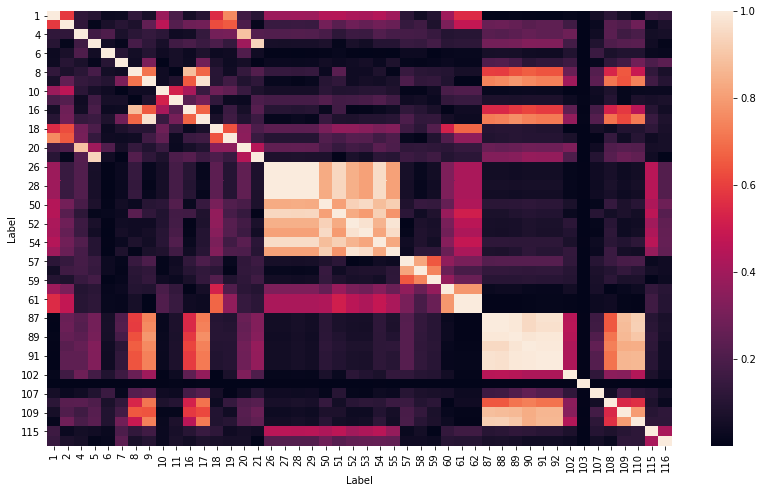

In [92]:
corr_mat = np.abs(df_clean.corr(method='pearson'))
sns.heatmap(corr_mat)
plt.show()

corr_thl = 0.15
corr_label = np.zeros(df_grouped.shape[1])

for i in label_target:
    corr_label = corr_label | (corr_mat[i] > corr_thl)

df_clean = df_clean.loc[:, corr_label]

Describe  dataset

In [93]:
print(df_clean.describe().transpose())

         count         mean        std          min          25%          50%  \
Label                                                                           
4      83751.0     6.661477   0.042329     6.210000     6.637200     6.658400   
5      83751.0     6.675937   0.027618     6.116000     6.665900     6.677000   
8      83751.0   102.547391   3.100177    94.335000   100.340000   102.050000   
11     83751.0    13.455714   0.589912    12.027000    13.052000    13.468000   
16     83751.0    10.888024   0.363838     9.751400    10.639000    10.858000   
17     83751.0    10.398421   0.554129     9.000000     9.958750    10.247000   
18     83751.0   432.042805  30.027955   287.000000   403.000000   434.000000   
20     83751.0    10.770612   7.895316     0.000000     4.524946    10.399938   
21     83751.0     6.346685   5.469337     0.000000     2.949953     5.749941   
59     83753.0    28.205664  93.949043     0.000000     0.000000     0.000000   
87     83753.0  1355.731138 

## Split dataset: train, validation and test

In [94]:
total_data = len(df_clean)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_clean[0:int(total_data*train_perc)]
val_df      = df_clean[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_clean[int(total_data*(train_perc + val_perc)):total_data]

## Data normalization

Min-max normalization

In [95]:
def f_normalize_minmax(df, train_df):
    norm_df = (df - train_df.min()) / (train_df.max() - train_df.min())
    return norm_df

def f_inv_normalize_minmax(norm_df, train_df):
    df = norm_df * (train_df.max() - train_df.min()) + train_df.min()
    return df

norm_train_df   = f_normalize_minmax(train_df, train_df)
norm_val_df     = f_normalize_minmax(val_df, train_df)
norm_test_df    = f_normalize_minmax(test_df, train_df)

Show tails with box plot

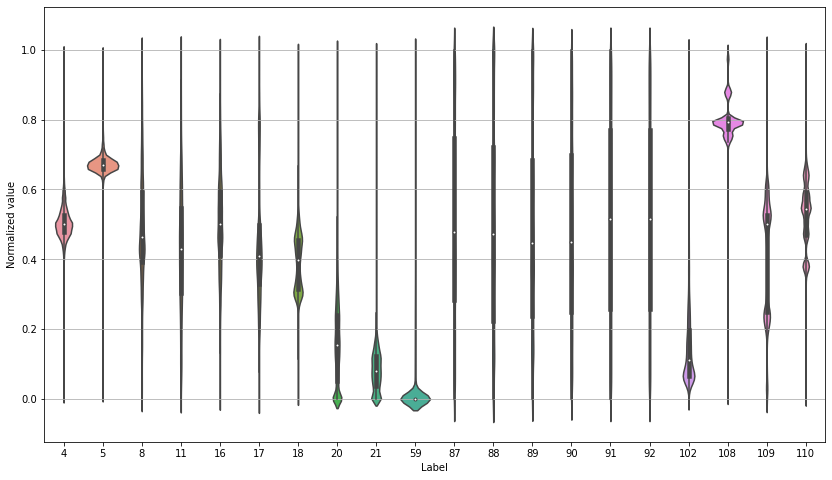

In [96]:
melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
plt.figure()
ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
plt.show()

Plot normalized data

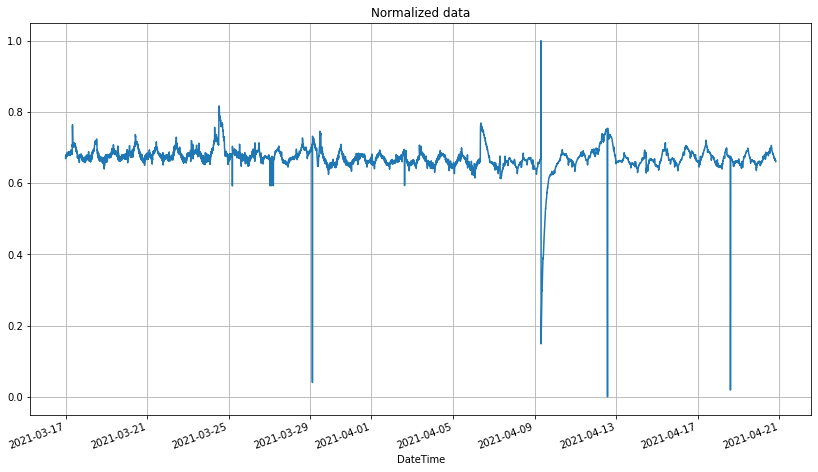

In [97]:
norm_train_df[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.title('Normalized data')
plt.show()

## Create input and target dataframe - Window generation

In [98]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 3
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('F'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [99]:
def plot_results(label_target, label_time, label, results, label_width):
    n_label = np.int(len(label_target))

    sensor_tag = list(label_target.values())

    print(label_time.shape)
    
    fig, ax = plt.subplots(n_label, sharex = 'all')
    
    for i in range(n_label):

        label_plot = label[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, label_plot, color = 'blue', label = 'Real')
        
        results_plot = results[((i) * label_width): ((i + 1)* label_width)]
        ax.plot(label_time, results_plot, color = 'orange', label = 'Prediction')

        ax.set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.show()

    pass

### Plotting - History

In [100]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    fig, ax = plt.subplots(2, sharex = 'all')

    # Plot training and validation accuracy per epoch
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].title.set_text('Training and validation MAE')

    # Plot training and validation loss per epoch
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].title.set_text('Training and validation loss')

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Architecture and Deployment

Callbacks

In [114]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

Training method

In [115]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, 
                    test_data, test_target, max_epochs, steps_epoch, batch_size, test_entry, label_width):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = 5)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
    
    broadcast_variables = hvd.callbacks.BroadcastGlobalVariablesCallback(0)
    
    metric_average = hvd.callbacks.MetricAverageCallback()
    
    callbacks = [early_stop, lr_scheduler, broadcast_variables, metric_average]

    # Set optimizer
    opt = tf.keras.optimizers.Nadam(learning_rate = 0.001 * hvd.size()) # Check!!!
    opt = hvd.DistributedOptimizer(opt)
    
    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = opt,
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    model.fit(x = train_data,
              y = train_target,
              steps_per_epoch =  steps_per_epoch // hvd.size(), # TODO
              callbacks = callbacks, 
              epochs  = max_epochs,
              verbose = 1,
              workers=4,
              shuffle = False,
              validation_data = (val_data, val_target),
              validation_steps= 3 * steps_per_epoch // hvd.size()) # TODO

    model.summary()
    
    # Model evaluate
    model.evaluate(test_data, test_target)

    # Test model
    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)
    
    test_prediction = np.squeeze(test_prediction)
    print(test_prediction.shape)
    
    # Plot results
    plot_results(label_target, test_target_time[test_entry], test_target[test_entry], test_prediction, label_width)

    plot_history(history)

    return history, test_prediction

test_entry = np.random.randint(0, 100)

# Models

## Linear model

In [116]:
def f_linear_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(units = 100, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 300, kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = len(label_target) * label_width, kernel_initializer='random_normal', bias_initializer='zeros')])
    return model

linear_model = f_linear_model(label_target, label_width)

In [117]:
max_epochs = 50
steps_epoch = 512
batch_size = 50


linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, 
                                                    test_data, test_target, max_epochs, steps_epoch, batch_size, test_entry, label_width)

AttributeError: module 'horovod.tensorflow' has no attribute 'callbacks'

## MLP model

In [ ]:
def f_mlp_model(label_target, label_width):
    model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
        
            tf.keras.layers.Dense(units = 200, activation = 'tanh', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 200, activation = 'tanh', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
        
            tf.keras.layers.Dense(units = 200, activation = 'tanh', kernel_initializer='random_normal', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),

        
            tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return model
    
mlp_model = f_mlp_model(label_target, label_width)

In [ ]:
max_epochs = 30
batch_size = 50
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## LSTM RNN model

In [ ]:
def f_lstm_model(input_shape, output_shape):
    model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units = 200, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),
        
            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

In [ ]:
max_epochs = 20
batch_size = 50
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, 
                                                test_data, test_target, max_epochs, batch_size, test_entry, label_width)

## GRU RNN model 

In [ ]:
def f_gru_model(input_shape, output_shape):
    model = tf.keras.Sequential([
            tf.keras.layers.GRU(units = 200, input_shape = input_shape, kernel_initializer='random_normal', bias_initializer='zeros', dropout=0.2, return_sequences=False),

            tf.keras.layers.Dense(output_shape)])
    return model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

In [ ]:
max_epochs = 20
batch_size = 50
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, 
                                              test_data, test_target, max_epochs, batch_size, test_entry, label_width)